# Semantic Segmentation

In this exercise we will train a UNet model to perform semantic segmentation of people contained in the pictures of the <a href="https://www.cis.upenn.edu/~jshi/ped_html/">PennFudanPed dataset</a>. This dataset contains pictures of people walking, and the relative masks:

Each person in the picture corresponds to a certain value in the mask. However, in this exercise we are interested in _semantic_ segmentation and not _instance_ segmentation, so we will consider all people as part of the same class. This means that we have two classes: people, and background (i.e., it is a binary segmentation)

In [29]:
import multiprocessing as mp, platform, torch
# On macOS & Linux we can safely use 'fork'
if platform.system() != "Windows":
    mp.set_start_method("fork", force=True)

In [ ]:
# --- Imports ---
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import multiprocessing

# --- Device selection ---
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print("CUDA is available. Using GPU (CUDA).")
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
    print("MPS is available. Using GPU (MPS) on Apple Silicon.")
else:
    DEVICE = torch.device('cpu')
    print("Neither CUDA nor MPS is available. Using CPU.")
print(f"Selected device: {DEVICE}")

# --- Dataset ---
class PennFudanDataset(Dataset):
    mean = (0.485, 0.456, 0.406)
    std  = (0.229, 0.224, 0.225)

    def __init__(self, root_dir, transform=None):
        self.image_dir = os.path.join(root_dir, "PNGImages")
        self.mask_dir  = os.path.join(root_dir, "PedMasks")
        self.transform = transform
        self.images = sorted([f for f in os.listdir(self.image_dir) if f.endswith(".png")])
        assert len(self.images) > 0, "No images found! Check root_dir."

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name  = self.images[idx]
        mask_name = img_name.replace(".png", "_mask.png")
        img_path  = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir,  mask_name)
        image = np.array(Image.open(img_path).convert("RGB"))
        mask  = np.array(Image.open(mask_path))
        mask[mask > 0] = 1  # Binary mask: 1 for pedestrian, 0 for background
        if self.transform:
            aug = self.transform(image=image, mask=mask)
            image, mask = aug["image"], aug["mask"]
        else:
            image = ToTensorV2()(image=image)["image"]
            mask  = torch.from_numpy(mask).long()
        return image, mask

# --- Collate function for DataLoader ---
def collate_fn_segmentation(batch):
    images, masks = zip(*batch)
    images = torch.stack(images, 0)
    masks = torch.stack(masks, 0)
    return images, masks

# --- Register for multiprocessing pickling ---
import sys, __main__
__main__.PennFudanDataset = PennFudanDataset
__main__.collate_fn_segmentation = collate_fn_segmentation

# --- Albumentations transforms ---
SIZE = 448
train_transforms = A.Compose([
    A.PadIfNeeded(SIZE, SIZE, border_mode=0, value=(0,255,0)),
    A.RandomCrop(SIZE, SIZE),
    A.HorizontalFlip(),
    A.OneOf([
        A.OpticalDistortion(p=0.3),
        A.GridDistortion(p=0.1),
        A.PiecewiseAffine(p=0.3),
    ], p=0.3),
    A.OneOf([
        A.HueSaturationValue(10, 15, 10),
        A.CLAHE(clip_limit=2),
        A.RandomBrightnessContrast(),
    ], p=0.3),
    A.Normalize(mean=PennFudanDataset.mean, std=PennFudanDataset.std),
    ToTensorV2(),
])
valid_transforms = A.Compose([
    A.PadIfNeeded(SIZE, SIZE, border_mode=0, value=(0,255,0)),
    A.CenterCrop(SIZE, SIZE),
    A.Normalize(mean=PennFudanDataset.mean, std=PennFudanDataset.std),
    ToTensorV2(),
])

# --- DataLoader creation ---
def get_pennfudan_loaders(
    root_dir,
    train_alb_transforms,
    valid_alb_transforms,
    batch_size=4,
    valid_split=0.2,
    num_workers=-1,
    shuffle_dataset=True,
    pin_memory=True
):
    if num_workers == -1:
        num_workers = multiprocessing.cpu_count()
    dataset_train = PennFudanDataset(root_dir=root_dir, transform=train_alb_transforms)
    dataset_valid = PennFudanDataset(root_dir=root_dir, transform=valid_alb_transforms)
    dataset_size = len(dataset_train)
    indices = list(range(dataset_size))
    split_idx = int(np.floor(valid_split * dataset_size))
    if shuffle_dataset:
        np.random.seed(42)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split_idx:], indices[:split_idx]
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    train_loader = DataLoader(
        dataset_train, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, collate_fn=collate_fn_segmentation, pin_memory=pin_memory
    )
    valid_loader = DataLoader(
        dataset_valid, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, collate_fn=collate_fn_segmentation, pin_memory=pin_memory
    )
    return {"train": train_loader, "valid": valid_loader}

# --- Example usage ---
# dl = get_pennfudan_loaders(
#     root_dir="PennFudanPed",
#     train_alb_transforms=train_transforms,
#     valid_alb_transforms=valid_transforms,
#     batch_size=4,
#     num_workers=2,   # Use 0 if you still get errors, then try 2 or more
# )
dl = get_pennfudan_loaders(
        root_dir="PennFudanPed",
        train_alb_transforms=train_transforms,
        valid_alb_transforms=valid_transforms,
        batch_size=4,
        num_workers=0,        # <── single-process loading
        pin_memory=False      # no benefit when num_workers=0
)



MPS is available. Using GPU (MPS) on Apple Silicon.
Selected device: mps


/var/folders/21/25m9bdqj7pv3mhbdjmv2z1w40000gn/T/ipykernel_63947/1751150149.py:69: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(SIZE, SIZE, border_mode=0, value=(0,255,0)),
/var/folders/21/25m9bdqj7pv3mhbdjmv2z1w40000gn/T/ipykernel_63947/1751150149.py:86: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(SIZE, SIZE, border_mode=0, value=(0,255,0)),


In [32]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
import sys

module_path = os.path.abspath(os.path.join('..', '.'))  # Goes up two levels to project root
if module_path not in sys.path:
    sys.path.append(module_path)

# from src.data import get_data_loaders
import matplotlib.pyplot as plt
from torch import nn
import torch
import segmentation_models_pytorch as smp
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import random
import metrics
import numpy as np

seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


### Transforms for Semantic Segmentation

Data augmentations are an important part of creating a performant neural network for image processing. In the case of segmentation, it is obviously very important that all the geometric transformations that we apply as part of data augmentation are applied to both the image and the mask, otherwise the mask would not represent the semantic information in the image anymore.

For this, we use the nice `albumentations` library that provides transformations that take care of that automatically. If you are curious to know how this is accomplished, consider this code in the `helpers.py` file, within the `PennFudanDataset` class:

```python
if self.transforms is not None:
    aug = self.transforms(image=img, mask=mask)
    img, mask = aug['image'], aug['mask']
```
As you can see, the transformations (contained in `self.transforms`) are applied to both the image and the mask.

We define two sets of transformations, one for the training set (containing augmentations) and one for the validation set (without augmentations).

> Since the dataset is small (there are only a total of 170 images) we cannot afford to divide it 3 ways (train, validation, and test). We therefore only divide it in two (train and validation). In a real-world use case, you would do k-fold cross-validation and repeat this split multiple times, recording the results of your training for each one of those. Here, for simplicity and to save time, we will not do that and will just train on the training dataset and evaluate on the validation dataset.

We can  now get the data loaders. Since this is mostly boilerplate code, we have saved you the trouble and provide a function for this in `helpers.py`. Please refer to the code if you are curious to see how this is accomplished.

In [21]:
import requests
import zipfile
import os
import shutil # For removing the __MACOSX directory

# --- Configuration ---
dataset_url = "https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip"
download_path = "./PennFudanPed.zip"  # Where to save the downloaded zip file
extract_to_folder = "./"              # Where to extract the dataset contents (e.g., current directory)
dataset_main_folder = os.path.join(extract_to_folder, "PennFudanPed") # Expected final folder name

# --- 1. Download the dataset ---
if not os.path.exists(dataset_main_folder):
    if not os.path.exists(download_path):
        print(f"Downloading PennFudanPed dataset from {dataset_url}...")
        try:
            response = requests.get(dataset_url, stream=True)
            response.raise_for_status() # Raise an exception for bad status codes
            with open(download_path, "wb") as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"Downloaded successfully to {download_path}")
        except requests.exceptions.RequestException as e:
            print(f"Error downloading dataset: {e}")
            # Consider exiting or raising the error if download fails
    else:
        print(f"Zip file {download_path} already exists. Skipping download.")

    # --- 2. Extract the dataset ---
    if os.path.exists(download_path) and not os.path.exists(dataset_main_folder):
        print(f"Extracting {download_path} to {extract_to_folder}...")
        try:
            with zipfile.ZipFile(download_path, "r") as zip_ref:
                zip_ref.extractall(extract_to_folder)
            print(f"Extracted successfully to {dataset_main_folder}")

            # Optional: Remove the __MACOSX folder if it exists (common in zips from macOS)
            macosx_folder = os.path.join(extract_to_folder, "__MACOSX")
            if os.path.exists(macosx_folder):
                print(f"Removing {macosx_folder} directory...")
                shutil.rmtree(macosx_folder)

            # Optional: Remove the zip file after extraction
            # print(f"Removing zip file {download_path}...")
            # os.remove(download_path)
            
        except zipfile.BadZipFile:
            print(f"Error: {download_path} is not a valid zip file or is corrupted.")
        except Exception as e:
            print(f"An error occurred during extraction: {e}")
    elif os.path.exists(dataset_main_folder):
        print(f"Dataset folder {dataset_main_folder} already exists. Skipping extraction.")
    elif not os.path.exists(download_path):
        print(f"Zip file {download_path} not found. Cannot extract.")
else:
    print(f"Dataset folder {dataset_main_folder} already exists. No action taken.")

# --- Verify expected structure (optional) ---
# The PennFudanPed dataset should have subdirectories like:
# - PennFudanPed/PNGImages/
# - PennFudanPed/PedMasks/
# - PennFudanPed/Annotation/ (not directly used by the typical Dataset class for masks)
if os.path.exists(dataset_main_folder):
    print("\nExpected subdirectories:")
    for sub_dir in ["PNGImages", "PedMasks"]:
        expected_path = os.path.join(dataset_main_folder, sub_dir)
        if os.path.exists(expected_path) and os.path.isdir(expected_path):
            print(f" - Found: {expected_path}")
        else:
            print(f" - MISSING: {expected_path} (This might cause issues with your Dataset class)")

else:
    print(f"Dataset main folder {dataset_main_folder} was not created. Please check download/extraction steps.")


Downloaded successfully to ./PennFudanPed.zip
Extracting ./PennFudanPed.zip to ./...
Extracted successfully to ./PennFudanPed

Expected subdirectories:
 - Found: ./PennFudanPed/PNGImages
 - Found: ./PennFudanPed/PedMasks


## Define the Model
We are going to use a UNet architecture:

We use [efficientnet-b2](https://paperswithcode.com/method/efficientnet) as backbone, pre-trained on ImageNet:

In [33]:
model = smp.Unet(
        encoder_name='efficientnet-b2',
        encoder_weights='imagenet',
        in_channels=3,
        # Binary classification
        classes=1
    )

## Training
As usual, we need to define a loss and an optimizer that will minimize that loss. We use the Dice loss, which directly optimizes the IoU metric that we are interested in. We also use a different learning rate for the backbone/encoder (the pre-trained EfficientNet) and the decoder (which is new and needs to be trained from scratch). We want the weights in the decoder to move much more quickly than the weights in the encoder, since the latter has been trained on ImageNet and is therefore already a very good feature extractor.

In [34]:
loss = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-1},
    {'params': model.encoder.parameters(), 'lr': 1e-3},
])

In [40]:
def train_one_epoch(epoch, model, data_loaders, optimizer, loss_function):
    model.train()
    model.to(DEVICE)
    train_loss = 0
    
    # Training loop
    for i, (imgs, masks) in enumerate(data_loaders["train"]):
        optimizer.zero_grad()
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)
        outputs = model(imgs)
        loss = loss_function(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(data_loaders["train"])

    # Validation
    model.eval()
    valid_loss = 0
    tp = fp = fn = tn = 0  # Initialize as scalars
    
    with torch.no_grad():
        for i, (imgs, masks) in enumerate(data_loaders["valid"]):
            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)
            outputs = model(imgs)
            loss = loss_function(outputs, masks)
            valid_loss += loss.item()

            # Convert outputs to binary predictions
            preds = (torch.sigmoid(outputs) > 0.5).float()
            
            # Flatten all predictions and masks
            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1)
            
            # Calculate confusion matrix
            tp += ((preds_flat == 1) & (masks_flat == 1)).sum().item()
            fp += ((preds_flat == 1) & (masks_flat == 0)).sum().item()
            fn += ((preds_flat == 0) & (masks_flat == 1)).sum().item()
            tn += ((preds_flat == 0) & (masks_flat == 0)).sum().item()

    # Compute IoU
    iou_score = tp / (tp + fp + fn + 1e-10)  # Avoid division by zero
    valid_loss /= len(data_loaders["valid"])

    return train_loss, valid_loss, iou_score

In [42]:
# Reduce the learning rate by a factor of 10 every 30 epochs
scheduler = StepLR(optimizer, step_size=30, gamma=0.1, verbose=False)

# Train for a few epochs, printing the progress along the way
for epoch in range(3):
    
    train_loss, valid_loss, iou = train_one_epoch(epoch, model, dl, optimizer, loss)
    print(f"EPOCH: {epoch + 1} - train loss: {train_loss} -  valid_loss: {valid_loss} - IoU: {iou:.3f}")
    
    scheduler.step()

EPOCH: 1 - train loss: 0.09235383833155912 -  valid_loss: 0.11431790722741021 - IoU: 0.801
EPOCH: 2 - train loss: 0.08671529854045194 -  valid_loss: 0.10622153679529826 - IoU: 0.798
EPOCH: 3 - train loss: 0.08117615650681888 -  valid_loss: 0.16699226035012138 - IoU: 0.717


## Results

Our model has an average IoU of almost 89%, which is very good considering how small this dataset is. Let's plot some results to have an idea of how the model is performing in reality:

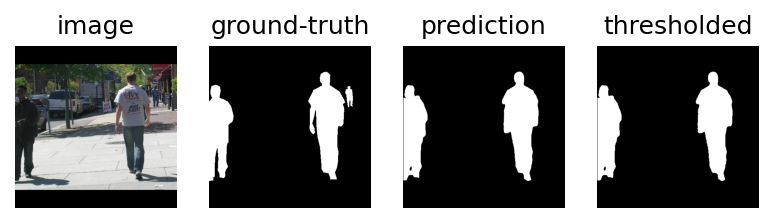

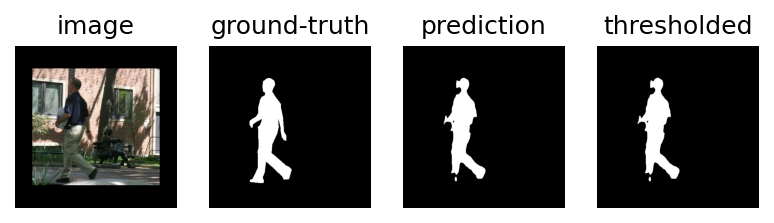

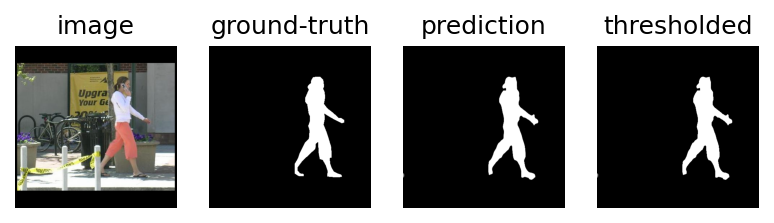

In [47]:
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_some_results(n=3):
    model.eval()                 # evaluation mode
    valid_it = iter(dl['valid'])
    mean = np.array(PennFudanDataset.mean)
    std  = np.array(PennFudanDataset.std)

    for _ in range(n):
        imgs, gt_masks = next(valid_it)      # imgs: [B,C,H,W]
        img      = imgs[0]                   # [C,H,W]
        gt_mask  = gt_masks[0]
        
        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(DEVICE))[0].cpu()  # [1,H,W] or [C,H,W]

        # un-normalise image
        img_np = img.permute(1, 2, 0).cpu().numpy()    # HWC in [0,1]
        img_np = (img_np * std + mean) * 255
        img_np = img_np.clip(0, 255).astype(np.uint8)

        # prepare prediction
        if pred.ndim == 3 and pred.shape[0] > 1:       # multi-channel logits
            pred_np = torch.softmax(pred, 0).argmax(0).numpy()
        else:                                          # single-channel logits
            pred_np = torch.sigmoid(pred).squeeze().numpy()

        # plot
        fig, ax = plt.subplots(1, 4, dpi=150)
        ax[0].imshow(img_np)
        ax[1].imshow(gt_mask.numpy(), cmap='gray', vmin=0, vmax=1)
        ax[2].imshow(pred_np, cmap='gray')
        ax[3].imshow(pred_np > 0.5, cmap='gray')
        for a in ax: a.axis('off')
        ax[0].set_title("image")
        ax[1].set_title("ground-truth")
        ax[2].set_title("prediction")
        ax[3].set_title("thresholded")
        plt.show()

plot_some_results()

In general, our model seems to perform very well given how little data it has seen. It's not perfect though. We can also see that sometimes the ground truth itself is imprecise and sometimes our model is actually better than the ground truth.

We can see here a few more interesting things. Looking at the prediction column (which is the output of the model as is), we can see that the people have structures that resemble their clothing. 

> Can you guess why that is the case?

Because UNet takes the tensor coming from the upsampling operations and sums it with the feature maps corresponding to that level in the decoder. In particular, the input image as-is gets summed to the output of the last layer in the decoder. Therfore some sharp features in the input image get projected into the prediction of the model.

It is also clear that our model underperforms on small "objects" (e.g., people far away). Small objects are classically difficult for both segmentation and object detection models. You can try to improve the situation by using a different loss, like the [Focal Tversky Loss](https://towardsdatascience.com/dealing-with-class-imbalanced-image-datasets-1cbd17de76b5).